In [1]:
# The data set for this project has been taken from Kaggle's Housing Data Set Knowledge Competition.
# This project aims at predicting house prices (residential) in Ames, Iowa, USA. 

# import required packages
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import numpy as np

In [2]:
# load data

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# data exploration: check if any missing value
print(train.columns[train.isnull().any()])

# calculate the percentage of missing data
miss = train.isnull().sum()/len(train)
print(miss[miss>0].sort_values())

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')
Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


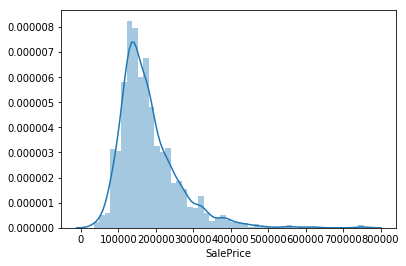

In [4]:
# data exploration: target variable

sns.distplot(train['SalePrice'])

In [5]:
# Sales price is right-skewed.
print('The Skewness of SalePrice is {}'.format(train['SalePrice'].skew()))

The Skewness of SalePrice is 1.8828757597682129


The Skewness of normalized SalePrice is 0.12133506220520406


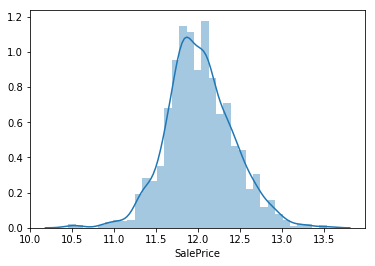

In [6]:
# Normalize target variable 
# NOTE: A normally distributed target variable helps in better modeling the relationship between target and independent variables.

target = np.log(train['SalePrice'])
print('The Skewness of normalized SalePrice is {}'.format(target.skew()))

sns.distplot(target)

In [7]:
# data exploration: check variables based on their correlation with the target variable
# separate numeric and non-numeric data

num_data = train.select_dtypes(include=[np.number])
del num_data['Id']
categ_data = train.select_dtypes(exclude=[np.number])

print('There are {} numeric and {} categorical variables in train data'.format(num_data.shape[1], categ_data.shape[1]))

There are 37 numeric and 43 categorical variables in train data


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


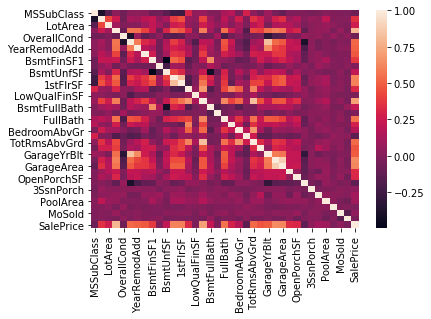

In [8]:
# find the correlation behavior of numeric variables

corr = num_data.corr()
sns.heatmap(corr)
print(corr['SalePrice'].sort_values(ascending=False))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2923: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


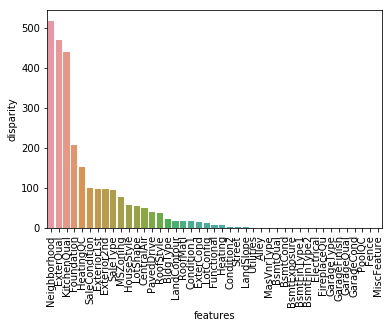

In [9]:
# use ANOVA test to understand the correlation between categorical variables and SalePrice
# Ho - There exists no significant difference between the groups
# Ha - There exists a significant difference between the groups
# calculate p-value and disparity; higher the disparity score, better the feature in predicting sale price

cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['SalePrice'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

categ_data['SalePrice'] = train.SalePrice.values
k = anova(categ_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt.show()

In [10]:
# remove outliers
# missing values

In [11]:
# encode all the categorical variables (ML does not accept categorical values)
# import function from sklearn

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def factorize(data, var, fill_na = None):
      if fill_na is not None:
            data[var].fillna(fill_na, inplace=True)
      le.fit(data[var])
      data[var] = le.transform(data[var])
      return data

In [12]:
# combine 2 data sets
alldata = train.append(test)
alldata.shape

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(2919, 81)

In [13]:
#create a label set
label_df = pd.DataFrame(index = train.index, columns = ['SalePrice'])
label_df['SalePrice'] = np.log(train['SalePrice'])
print("Training set size:", train.shape)
print("Test set size:", test.shape)

Training set size: (1460, 81)
Test set size: (1459, 80)


In [15]:
# model training and evaluation
# XGBoost
import xgboost as xgb
regr = xgb.XGBRegressor(colsample_bytree=0.2,
                       gamma=0.0,
                       learning_rate=0.05,
                       max_depth=6,
                       min_child_weight=1.5,
                       n_estimators=7200,
                       reg_alpha=0.9,
                       reg_lambda=0.6,
                       subsample=0.2,
                       seed=42,
                       silent=1)

regr.fit(train, label_df)


ModuleNotFoundError: No module named 'xgboost'

In [18]:
# Lasso regression

from sklearn.linear_model import Lasso

#found this best alpha through cross-validation
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train, label_df)

ValueError: could not convert string to float: 'RL'

In [ ]:
# RMSE
